In [6]:
import numpy as np
import cv2 as cv
from matplotlib.mlab import magnitude_spectrum


class filters:
    image_path : str = None

    def __init__(self, image_path: str):
        if(image_path is None):
            raise ValueError("Dime la dirección de la imagen")
            __del__()
        self.image_path = image_path
        try:
                self.image = cv.imread(self.image_path)
        except Exception as e:
                raise ValueError("Error al cargar la imagen: " + str(e))
                __del__()

    def ffts_filter_lowpass(self, radio: float = 0.14):
        """Filtro pasa bajas: suaviza la imagen, elimina ruido
        recibo el radio normalizado entre 0 y 0.5
        retorno una tupla con la imagen filtrada, imagen en frecuencia y la máscara usada
        """
        Nf, Nc = self.image.shape[:2]

        # Malla de frecuencias normalizadas
        fx = np.arange(-Nc // 2, Nc // 2)
        fy = np.arange(-Nf // 2, Nf // 2)
        X, Y = np.meshgrid(fx, fy)
        D = np.sqrt(X.astype(float) ** 2 + Y.astype(float) ** 2)
        D = D / (D.max() if D.max() != 0 else 1.0)

        # Máscara pasa bajas: mantiene frecuencias < radio
        mask = (D < radio).astype(np.float64)

        # Procesar cada canal
        channels = cv.split(self.image)
        filtered_channels = []
        magnitude_specs = []

        for ch in channels:
            img_filtered, mag_spec = self.__process_channels_fft(ch, mask)
            filtered_channels.append(img_filtered)
            magnitude_specs.append(mag_spec)

        # Retornar primer canal como referencia
        return cv.merge(filtered_channels), magnitude_specs, mask

    def ffts_filter_highpass(self, radio: float = 0.14):
        """Filtro pasa altas: realza bordes y detalles"""
        Nf, Nc = self.image.shape[:2]

        fx = np.arange(-Nc // 2, Nc // 2)
        fy = np.arange(-Nf // 2, Nf // 2)
        X, Y = np.meshgrid(fx, fy)
        D = np.sqrt(X.astype(float) ** 2 + Y.astype(float) ** 2)
        D = D / (D.max() if D.max() != 0 else 1.0)

        # Máscara pasa altas: mantiene frecuencias >= radio
        mask = (D >= radio).astype(np.float64)

        channels = cv.split(self.image)
        filtered_channels = []
        magnitude_specs = []

        for ch in channels:
            img_filtered, mag_spec = self.__process_channels_fft(ch, mask)
            filtered_channels.append(img_filtered)
            magnitude_specs.append(mag_spec)

        # Retornar primer canal como referencia
        return cv.merge(filtered_channels), magnitude_specs, mask

    def __process_channels_fft(self, ch, mask):
        ch_f = ch.astype(np.float64)
        F = np.fft.fft2(ch_f)
        Fshift = np.fft.fftshift(F)

        # Calcular espectro de magnitud ANTES de aplicar el filtro
        magnitude_spec = 20 * np.log10(np.abs(Fshift) + 1e-8)

        G_shift = Fshift * mask
        G = np.fft.ifftshift(G_shift)
        img_filtered = np.fft.ifft2(G)
        img_filtered = np.abs(img_filtered)
        img_filtered = np.clip(img_filtered, 0, 255).astype(np.uint8)

        return img_filtered, magnitude_spec


    """"""
    def __del__(self):

        print("Se destruyo la instancia filters")


In [7]:
img = "images_pr/imagenes_con_ruido/lena_gray_512_512_variance_400.png"
filt = filters(img)
img_lowpass = filt.ffts_filter_lowpass(radio=0.14)
img_highpass = filt.ffts_filter_highpass(radio=0.14)

Se destruyo la instancia filters


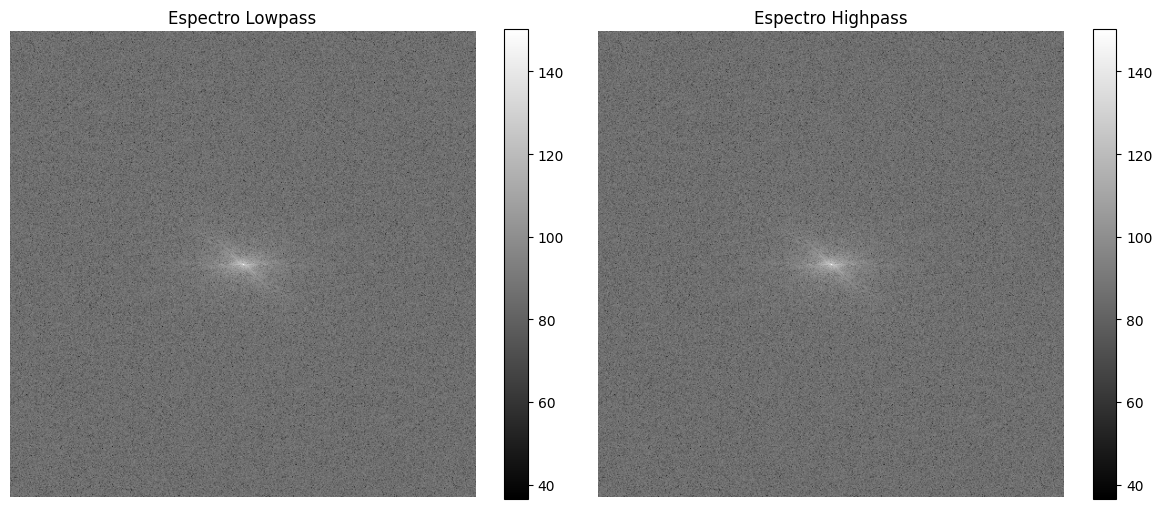

KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt

# Mostrar imágenes con OpenCV
cv.imshow("Original", filt.image)
cv.imshow("Lowpass Filtered", img_lowpass[0])
cv.imshow("Highpass Filtered", img_highpass[0])

# Mostrar espectros con matplotlib
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_lowpass[1][0], cmap='gray')
plt.title("Espectro Lowpass")
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_highpass[1][0], cmap='gray')
plt.title("Espectro Highpass")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

cv.waitKey(0)
cv.destroyAllWindows()
